In [51]:
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.stats import pareto
import matplotlib.pyplot as plt
from scipy.sparse import dok_matrix
from math import log10
import numpy as np
import networkx as nx
import pickle
from util import *
import pandas as pd
from scipy.stats import pearsonr
from IPython.display import HTML, display
from wordcloud import WordCloud
from pyvis import network as net

In [2]:
with open("pkl/preprocessed_bitcoin_noloops.pkl", 'rb') as f:
    data = pickle.load(f)

post_num = None

voca2idx = {w: i for i, w in enumerate(data['voca'])}
voca = data['voca']

if not(post_num is None):
    data['posts'] = data['posts'][:post_num]


In [3]:
# add the retweets to the user network, retweet_user_network will be used to 
# indicate whether an edge is a retweet or not
data['user_network'] = nx.compose(data['user_network'], data['retweet_user_network'])

In [4]:
data.keys()

dict_keys(['user_network', 'retweet_user_network', 'time_posts', 'user_time_posts', 'user_posts', 'user_comments', 'user_posts_num', 'get_comment_num', 'write_comment_num', 'verified', 'retweet_count', 'followers_count', 'favorite_count', 'posts', 'voca', 'word_freq'])

In [5]:
# user_score = nx.pagerank(data['user_network'], tol=1e-8, max_iter=200)
hubs, user_score = nx.hits(data['user_network'], max_iter=200)
total_user_num = len(data['user_network'].nodes())
top_users = sorted(user_score, key=user_score.get, reverse=True)

fwrite = open('hits_user_score_post_num.tsv', 'w')
fwrite.write("id\tlog id\tuser\tscore\tpost num\tget comment num\twrite comment num\n")
for i, user in enumerate(top_users):
    fwrite.write("{}\t{}\t{}\t{}\t{}\t{}\t{}\n".format(
        i + 1, log10(i+1), user, user_score[user], data['user_posts_num'][user], 
        data['get_comment_num'][user], data['write_comment_num'][user]))
fwrite.close()
# 전체 게시물 수와 상위유저+하위유저 게시물 갯수가 다른건 아예 소통이 없던 유저의 게시물이 있기 때문!

total 94745


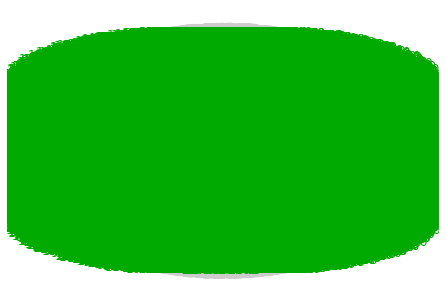

In [31]:
# print network
n_nodes = 30
# node_sample = list(data['user_network'].nodes)[:(n_nodes // 2)] + list(data['retweet_user_network'].nodes)[:(n_nodes // 2)] 
node_sample = list(data['user_network'].nodes)
# add any other nodes pointing to this sample just for opinion leaders, up to a set amount
# neighbors = []
# n_extend = 5
# for node in node_sample:
#     if node in top_users:
#         preds = [node for node in list(data['user_network'].predecessors(node))[:n_extend] if node not in top_users]
#         neighbors.extend(preds)

# node_sample.extend(neighbors)

labels = None

# color nodes by authority
colors = ['#CCCCCC'] * len(node_sample)

for i, node in enumerate(node_sample):
    # set authority leaders to blue
    if node in top_users:
        colors[i] = '#bbbbFF'

    # set follower count label
    # labels[node] = i



# subgraph = nx.subgraph(data['user_network'], node_sample)

# # print id's in table
# id_df = pd.DataFrame(columns=["Index", "User_ID"])
# id_df.Index = list(range(len(node_sample)))
# id_df.User_ID = node_sample

# print('total', len(node_sample))
# # display(HTML(id_df.to_html()))
# nx.draw(data['user_network'], node_color=colors, labels=labels, font_color='#00aa00')
# plt.savefig("graph.pdf")

In [26]:
graph = net.Network(width=1920, height=1080, directed=True,font_color='#ff8000',bgcolor='white')

# set the edge color

# automatic (not customizable)
# pyviz_net.from_nx(subgraph)

# for each node and its attributes in the networkx graph
for node,node_attrs in subgraph.nodes(data=True):
    node_attrs['size'] = 10
    node_attrs['physics'] = True
    node_attrs['color'] = '#606060'

    if node in top_users:
        node_attrs['color'] = '#FF7F7F'
    
    graph.add_node(node,**node_attrs)

# for each edge and its attributes in the networkx graph
# borrowed from https://gist.github.com/maciejkos/e3bc958aac9e7a245dddff8d86058e17 :)
for source,target,edge_attrs in subgraph.edges(data=True):
    # add the edge
    node_attrs['physics'] = True


    if source in data['retweet_user_network']:
        graph.add_edge(source,target,color='#00aced')
    else:
        graph.add_edge(source,target,color='black')

graph.show("example.html")

In [5]:
# for user in top_users:
#     print(f"{user} {user_score[user]} {len(data['user_network'].adj[user])}")

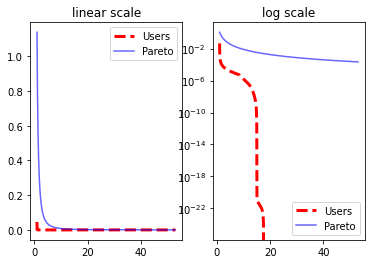

In [6]:
sorted_scores = sorted([v for v in user_score.values()], reverse=True)

# b for standard 80/20 distribution
b = 1.16
fig, ax = plt.subplots(1, 2)
mean, var, skew, kurt = pareto.stats(b, moments='mvsk')
x = np.linspace(pareto.ppf(0.01, b), pareto.ppf(0.99, b), len(sorted_scores))

ax[0].title.set_text("linear scale")
ax[0].plot(x, sorted_scores, "red", lw=3, linestyle='dashed', label='Users')
ax[0].plot(x, pareto.pdf(x, b), 'blue', alpha=0.6, label='Pareto')

ax[1].title.set_text("log scale")
ax[1].set_yscale('log')
ax[1].plot(x, sorted_scores, "red", lw=3, linestyle='dashed', label='Users')
ax[1].plot(x, pareto.pdf(x, b), 'blue', alpha=0.6, label='Pareto')

ax[0].legend()
ax[1].legend()

In [7]:
# Fit distribution
# todo: look at this SO thread to see if there are any other distributions that this data may fit
# https://stackoverflow.com/questions/37487830/how-to-find-probability-distribution-and-parameters-for-real-data-python-3

pareto.fit(sorted_scores)

/home/matthew/programming/topic_modeling_research/venv/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


(3.8514002899814344, -2.804123136987289e-07, 2.804123136013793e-07)

In [21]:
max(data['followers_count'].values())

55712081

correlation (0.05235910955146485, 1.964941012774607e-60)


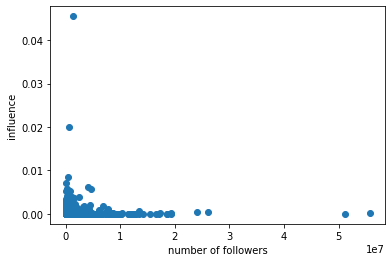

In [22]:
# see if there's any correlation between followers_count and authority

user_followers = [data['followers_count'][user] for user in user_score.keys()]

print("correlation", pearsonr(list(user_score.values()), user_followers))
plt.scatter(user_followers, user_score.values())
plt.xlabel('number of followers')
plt.ylabel('influence')
plt.show()

In [10]:
# users = {u: len(v) for u, v in sorted(data['user_network'].adj.items(), key=lambda e: len(e[1]), reverse=True)}

# for user, n_adj in users.items():
#     print(user, n_adj, user_score[user])

In [32]:
# construct the term frequency matrix for entire community and run 
# topic modeling for it
counter = 0
total_len = len(data['posts'])

tdm_tot = dok_matrix((len(data['posts']), len(voca)), dtype=np.float32)
for i, post in enumerate(data['posts']):

    if counter % 1000 == 0:
        print(f"\r{counter/total_len * 100:.2f}% done", end='')

    for word in post:
        tdm_tot[i, voca2idx[word]] += 1

    counter += 1
        

print(f"\r{100:.2f}% done", end='')

tdm_tot = normalize(tdm_tot)
# compressed sparse row matrix, where row operations are rendered more efficient
# in our case documents are stored in the rows
tdm_tot = tdm_tot.tocsr()

100.00% done

In [59]:
K = 10
alpha_W = 0
alpha_H = 0

modeling_type = 'lda'

if modeling_type == 'nmf':
    nmf = NMF(n_components=K, alpha_W=alpha_W, alpha_H=alpha_H, max_iter=500)
    nmf.fit(tdm_tot)
    H_total = nmf.components_
elif modeling_type == 'lda':
    lda = LatentDirichletAllocation(n_components=K, max_iter=10)
    lda.fit_transform(tdm_tot).T
    H_total = lda.components_

In [ ]:
# 상위 유저 분석!
# segregate users based on hits algorithm. Moving those in the top
# 20 percent into a separate group. top_index is just the cutoff
# point for where this gruop is
acc_sum = 0
top_index = 0
score_sum = sum(user_score.values())
for i, top_user in enumerate(sorted(user_score, key=user_score.get, reverse=True)):
    acc_sum += user_score[top_user]/score_sum
    if acc_sum > 0.8:
        top_index = i
        break

top_users = top_users[:top_index]
print(f"top users {len(top_users)} total users {len(data['user_posts'])} ")
print(f"{top_index/len(user_score):.2f}% of users account for ~80% of the authority.")

top users 2565 total users 356724 
0.03% of users account for ~80% of the authority.


In [ ]:
top_user_posts = []
for user in top_users:
    
    for post in data['user_posts'][user]:
        top_user_posts.append(post)

In [ ]:
# top_verified = [data['verified'][user] for user in top_users].count(True) / len(top_users)
# total_verified = list(data['verified'].values()).count(True) / len(data['verified']) 
# print(f"{top_verified*100:.2f}% of opinion leaders are verified")
# print(f"{total_verified*100:.2f}% of total users are verified")
# print()

# total_followers = 0

# for user in top_users:
#     total_followers += data['followers_count'][user]

# print(f"average opinion leader followers {total_followers / len(top_users):.0f}")
# print(f"average total followers {sum(data['followers_count'].values()) / len(data['followers_count']):.0f}")

# total_followers_sorted = {k: v for k, v in sorted(data['followers_count'].items(), key=lambda item: item[1])}

# print(f"median total followers {total_followers_sorted[int(len(data['followers_count']) / 2)]}")

In [ ]:
# TDM for top users
tdm_top = dok_matrix((len(top_user_posts), len(voca)), dtype=np.float32)
for i, post in enumerate(top_user_posts):
    for word in post:
        tdm_top[i, voca2idx[word]] += 1
        
tdm_top = normalize(tdm_top)
tdm_top = tdm_top.tocsr()
print(tdm_top.shape)

(361956, 61153)


In [ ]:
if modeling_type == 'nmf':
    nmf = NMF(n_components=K, alpha_H=0, alpha_W=0, max_iter=500)
    nmf.fit(tdm_top)
    H_top = nmf.components_
elif modeling_type == 'lda':
    lda = LatentDirichletAllocation(n_components=K, max_iter=10)
    lda.model.fit_transform(tdm_top).T
    H_top = nmf.components_

NameError: name 'LatentDirichletAllocation' is not defined

In [ ]:
# 하위 유저 분석!
# everything EXCEPT for the top users
low_users = sorted(user_score, key=user_score.get, reverse=False)[:-top_index]

maj_user_posts = []
for user in low_users:
    for post in data['user_posts'][user]:
        maj_user_posts.append(post)

In [ ]:
# TDM for majority users
tdm_maj = dok_matrix((len(maj_user_posts), len(voca)), dtype=np.float32)
for i, post in enumerate(maj_user_posts):
    for word in post:
        tdm_maj[i, voca2idx[word]] += 1
        
tdm_maj = normalize(tdm_maj)
tdm_maj = tdm_maj.tocsr()
print(tdm_maj.shape)

(1427387, 61153)


In [ ]:
if modeling_type == 'nmf':
    nmf = NMF(n_components=K, alpha_H=0, alpha_W=0, max_iter=500)
    nmf.fit(tdm_maj)
    H_low = nmf.components_
elif modeling_type == 'lda':
    lda = LatentDirichletAllocation(n_components=K, max_iter=10)
    lda.model.fit_transform(tdm_maj).T
    H_low = nmf.components_

/home/matthew/programming/topic_modeling_research/venv/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/home/matthew/programming/topic_modeling_research/venv/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import linear_sum_assignment

# hungarian algorithm
top_distances = pairwise_distances(H_total, H_top, metric='cosine')
_, top_indices = linear_sum_assignment(top_distances)

low_distances = pairwise_distances(H_total, H_low, metric='cosine')
_, low_indices = linear_sum_assignment(low_distances)

top_similarity_average = 0
low_similarity_average = 0

top_similarities = []
low_similarities = []

for k in range(K):
    top_similarity = cosine_similarity(H_top[top_indices[k]].reshape(1, -1), H_total[k].reshape(1,-1))[0, 0]
    low_similarity = cosine_similarity(H_low[low_indices[k]].reshape(1, -1), H_total[k].reshape(1,-1))[0, 0]
    top_similarity_average += top_similarity
    low_similarity_average += low_similarity

    top_similarities.append(top_similarity)
    low_similarities.append(low_similarity)
   
    print(f"total users: {k}th topic")
    for i in H_total[k, :].argsort()[::-1][:20]:
        print(voca[i], end=' ')
    print()
    
    print(f"top users: {top_indices[k]}th topic, similarity - {top_similarity}")
    for i in H_top[top_indices[k]].argsort()[::-1][:20]:
        print(voca[i], end=' ')
    print()
    
    print(f"majority users: {low_indices[k]}th topic, similarity - {low_similarity}")
    for i in H_low[low_indices[k]].argsort()[::-1][:20]:
        print(voca[i], end=' ')
    print()
    
    print()
    
top_similarity_average /= K
low_similarity_average /= K

print(top_similarity_average, low_similarity_average)

total users: 0th topic
bitcoin via new cash free money news mining gold time year trade get day future amp litecoin wallet ethereum btcusd 
top users: 0th topic, similarity - 0.9963408708572388
bitcoin buy money cash gold paypal new amp skrill paysafecard okpay year future via make value know bank use network 
majority users: 0th topic, similarity - 0.9992428421974182
bitcoin via cash new trade gold year time day money future free get coin avg block gmt mining btcusd bcoin 

total users: 1th topic
btc usd volume time traded btcusd binance utc bittrex miner total size fee average doge sat block update dominance long 
top users: 1th topic, similarity - 0.9877558946609497
btc buy read alt ltc bch btcusd trading binance day vaultmex short chart long amp support market orderbook skrill paypal 
majority users: 1th topic, similarity - 0.9952579736709595
btc volume usd btcusd doge live profit market alt binance short current long sat vircurex idol time whale ranking bittrex 

total users: 2th 

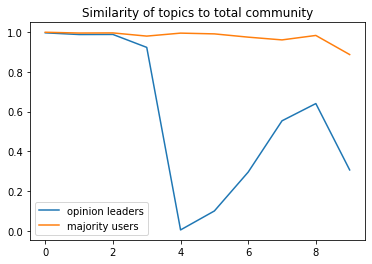

In [ ]:
'''
The graph of the similarity scores between majority and opinion leaders vs the H_total
'''
x = range(len(top_similarities))

plt.title('Similarity of topics to total community')
plt.plot(x, top_similarities, label='opinion leaders')
plt.plot(x, low_similarities, label='majority users')
plt.legend()
plt.show()

In [ ]:
print(f"opinion leader average: {np.average(top_similarities)}")
print(f"majority users average: {np.average(low_similarities)}")

opinion leader average: 0.5795779228210449
majority users average: 0.9761350750923157


In [ ]:
# Generate a word cloud image
top_user_text = ' '.join(' '.join(post_list) for post_list in top_user_posts)
maj_user_text = ' '.join(' '.join(post_list) for post_list in maj_user_posts)

wordcloud_kwargs = {
    'collocations': False,
    'width': 720,
    'height': 480,
    'max_words': 50,
    'stopwords': ['bitcoin', 'btc', 'crypto', 'cryptocurrency']
}

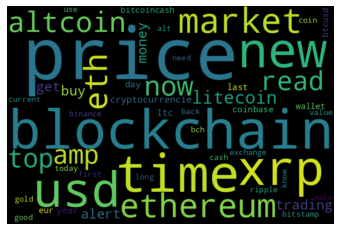

In [ ]:
top_user_wordcloud = WordCloud(**wordcloud_kwargs).generate(top_user_text)

plt.imshow(top_user_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

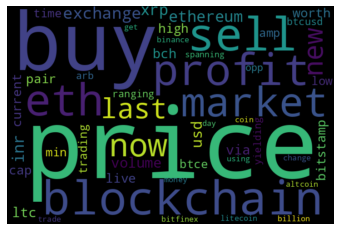

In [ ]:
maj_user_wordcloud = WordCloud(**wordcloud_kwargs).generate(maj_user_text)

plt.imshow(maj_user_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()